# Reads files with face pictures and cleans them

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random
from IPython.display import clear_output
import pickle

In [2]:
# Helper: displays progress bar

def jupyter_progress(percentage):
    clear_output(wait=True)
    bar_length = 20
    block = int(round(percentage * bar_length))
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), percentage * 100)
    print(text)

In [3]:
# Helper: Given a filename and a function, only runs the function if the file does not exist and then
# writes the return value to that file. Afterwards, returns the content of that file.

def load_maybe_file(generator, filename, binary=False):
    binflag = 'b' if binary else ''
    
    if not os.path.exists(filename):
        data = generator()
        if data is not None:
            with open(filename, 'w'+binflag) as f:
                f.write(data)
    with open(filename, 'r'+binflag) as f:
        return f.read()

In [4]:
OPENCV_DIR = '/usr/share/opencv4/'

In [5]:
face_model = OPENCV_DIR + 'haarcascades/haarcascade_frontalface_alt.xml'
face_cascade = cv2.CascadeClassifier(face_model)
eye_model = OPENCV_DIR + 'haarcascades/haarcascade_eye_tree_eyeglasses.xml'
eye_cascade = cv2.CascadeClassifier(eye_model)

def detect_face_and_eyes(image):
    return face_cascade.detectMultiScale(image), eye_cascade.detectMultiScale(image)

### Test a random image for face detection

photos/faces/getty-nats-image.jpg
(300, 300, 3)


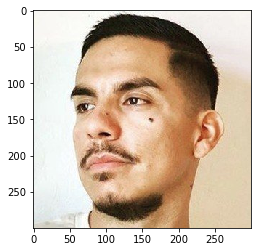

In [59]:
all_photos = ['photos/faces/' + f for f in os.listdir('photos/faces')]
filename = random.choice(all_photos)
print(filename)

img = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
print(img.shape)

plt.imshow(img, cmap='gray')

In [60]:
faces, eyes = detect_face_and_eyes(img)
print(faces)
print(eyes)

[[ 15  53 182 182]]
[[117 105  43  43]
 [ 53 116  35  35]]


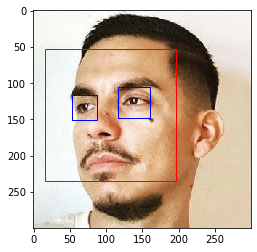

In [61]:
figure, axes = plt.subplots(1)
axes.imshow(img, cmap='gray')
for face in faces:
    rect = patches.Rectangle((face[0], face[1]), face[2], face[3], linewidth=1, edgecolor='r', facecolor='none')
    axes.add_patch(rect)
for eye in eyes:
    rect = patches.Rectangle((eye[0], eye[1]), eye[2], eye[3], linewidth=1, edgecolor='b', facecolor='none')
    axes.add_patch(rect)
plt.show()

### Collect data of all faces

In [9]:
def generate_face_and_eyes():
    face_and_eyes = dict()

    i = 0.0
    for f in all_photos:
        i += 1
        jupyter_progress(i / len(all_photos))
        print(f)
        img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
        faces, eyes = detect_face_and_eyes(img)
        face_and_eyes[f] = (faces, eyes)
    
    return pickle.dumps(face_and_eyes)

In [10]:
face_and_eyes = pickle.loads(load_maybe_file(generate_face_and_eyes, 'face_eyes.pickle', binary=True))

Progress: [####################] 100.0%
photos/faces/torres-fernando-image.jpg


In [12]:
ratios = {'perfect': 0, 'little': 0, 'much': 0}
for k, v in face_and_eyes.items():
    n_faces = len(v[0])
    n_eyes = len(v[1])
    
    if n_faces < 1 or n_eyes < 2:
        ratios['little'] += 1
    elif n_faces == 1 and n_eyes == 2:
        ratios['perfect'] += 1
    else:
        ratios['much'] += 1
ratios

{'perfect': 8423, 'little': 6228, 'much': 686}

In [62]:
# Reads a face photo and uses the face detection data to crop the image down to the face only.
def extract_pure_face(filename):
    margin = 20
    faces, eyes = face_and_eyes[f]
    face = faces[0]
    img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    wid, hei, _ = img.shape
    
    y1 = max(0, face[1]-margin)
    y2 = min(hei, face[1]+face[3]+margin)
    x1 = max(0, face[0]-margin)
    x2 = min(wid, face[0]+face[2]+margin)
    return img[y1:y2, x1:x2]

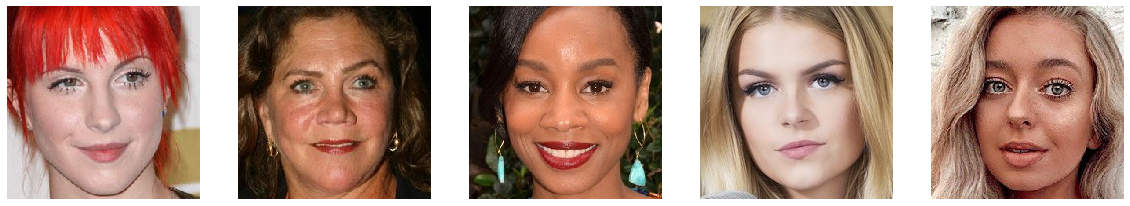

In [63]:
# Show 10 random faces with perfect ratio
perfect_faces = []
for k, v in face_and_eyes.items():
    n_faces = len(v[0])
    n_eyes = len(v[1])
    if n_faces == 1 and n_eyes == 2:
        perfect_faces.append(k)

sample = random.choices(perfect_faces, k=5)

plt.figure(figsize=(20, 20))
for i, f in enumerate(sample):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(extract_pure_face(f))

In [66]:
try:
    os.mkdir("photos/faces_pure")
except FileExistsError:
    pass


for i, f in enumerate(perfect_faces):
    jupyter_progress(i / len(perfect_faces))
    print(f)
    img = cv2.cvtColor(extract_pure_face(f), cv2.COLOR_RGB2BGR)
    cv2.imwrite('photos/faces_pure/' + f.split('/')[-1], img)


Progress: [####################] 100.0%
photos/faces/hoellein-olivia-image.jpg
